In [4]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
%matplotlib inline

##### Next steps :

- check : https://fr.wikipedia.org/wiki/RANSAC, better algo, and hyperparameter tuning

- clean, rephrase, etc

## Polar and cartesian projection

In [5]:
# Angle covered by the sensor
theta = np.linspace(0, 2 * np.pi)

# Sample frequency of the sample (rad⁻¹)
s_freq = 1

# Obstacles to be detected (a 5m circular room, for now)
obst = np.ones_like(theta) * 5

In [6]:
def cartesian_to_polar(x, y):
    theta = np.arctan2(y, x)
    r = np.sqrt(x**2 + y**2)
    return r, theta

def polar_to_cartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

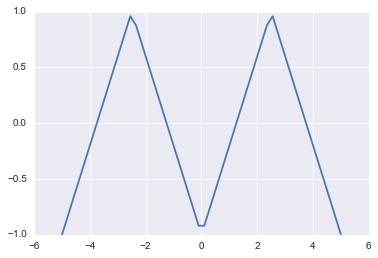

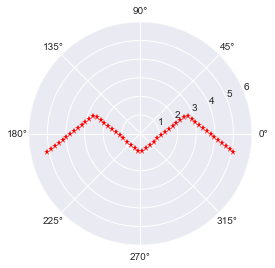

In [7]:
yp = np.array([-1, 1, -1, 1, -1])
xp = np.array([-5, -2.5, 0, 2.5 ,5])
t = np.linspace(-5,5)

saw = np.interp(t,xp, yp)
plt.plot(t, saw)

r_saw, theta_saw = cartesian_to_polar(t, saw)
plt.figure()
plt.polar(theta_saw, r_saw, 'r*')

## Getting the world map

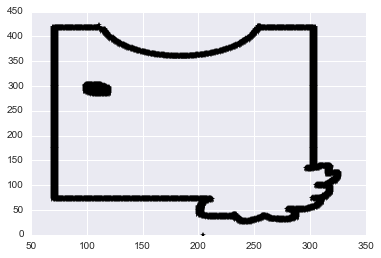

In [8]:
world = plt.imread('/home/raphael/PycharmProjects/rafiki/MapperBot_v0/assets/map_pipou.png')

world = world[:,:,0]
world = 1 - world

# Convert gridmap matrixinto cartesian coordinates
x, y = np.where(world > 0)
plt.plot(x, y,'k*')
plt.title = "Strangely upside down, but that'll do"

### Recreating sensor data

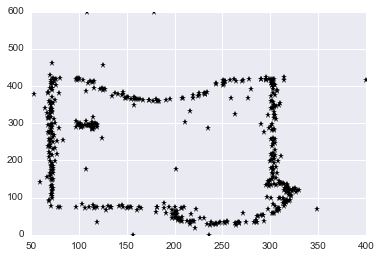

In [9]:
n = x.shape[0]
n_sample = 500

x_world, y_world = world.shape

sample_idx = np.random.randint(0, n+1, size=n_sample)
x_err, y_err = np.random.standard_cauchy(size=(2,n_sample))

x_sensor = (x[sample_idx] + x_err).clip(50, x_world)
y_sensor = (y[sample_idx] + y_err).clip(0, y_world)

plt.plot(x_sensor, y_sensor, 'k*')

## Line extraction (RanSaC)

**While :**
• there are still unassociated laser readings,  
• and the number of readings is larger than the consensus, 
• and we have done less than N trials. 
**Do**
- Select a random laser data reading. 
- Randomly sample S data readings within D degrees of this laser data reading (for example, choose 5 sample readings that lie within 10 degrees of the randomly selected laser data reading). 
- Using these S samples and the original reading calculate a least squares best fit line. 
- Determine how many laser data readings lie within X centimeters of this best fit line.   


- **If** the number of laser data readings on the line is above some consensus C do the following: 
    - calculate new least squares best fit line based on all the laser readings determined to lie on the old best fit line. 
    - add this best fit line to the lines we have extracted. 
    - remove the number of readings lying on the line from the total set of unassociated readings. 
    
This algorithm can thus be tuned based on the following parameters: 

N – Max number of times to attempt to find lines.

S – Number of samples to compute initial line. 

D – Degrees from initial reading to sample from.  

X – Max distance a reading may be from line to get associated to line. 

C – Number of points that must lie on a line for it to be taken as a line. 

In [10]:
def squared_dist(x, m, p):
    " Returns the distance of a point to a line defined by its slope and intercept."
    return np.abs(x[1] - m*x[0] - p) / np.sqrt(1 + m**2)

## Line model

In [11]:
class Line_model(object):
    def __init__(self, slope, intercept, points, fitted=None):
        self.slope = slope
        self.interceipt = intercept
        self.points = points
        self.fitted = fitted

In [12]:
## Note : instead of degrees for D, we will use "k neighbours" adjacent to the sample (<- unclear again)

### KNN search... (while we're at it)

In [13]:
def knn_search(x, data, k):
    "Returns the points *AND* the knn"
    
    # Safely take too short dataset.
    k = min(k, data.shape[1])
    
    sq_dist = (x[0] - data[0,:])**2 + (x[1] - data[1,:])**2
    idx = np.argsort(sq_dist)
    return idx[:k+1]

### PCA

The classic approach to PCA is to perform the eigendecomposition on the covariance matrix

In [14]:
x = np.arange(-10, 20, 2)
err =  np.random.standard_cauchy(size=x.shape[0])
y = x + err

X = np.vstack([x,y])


X_cov = np.cov(X)
eig_vals, eig_vecs = np.linalg.eig(X_cov)

eig_vecs

array([[ 0.72707485, -0.6865582 ],
       [ 0.6865582 ,  0.72707485]])

It's about time to get to the really interesting part: The construction of the projection matrix that will be used to transform the Iris data onto the new feature subspace. Although, the name "projection matrix" has a nice ring to it, it is basically just a matrix of our concatenated top k eigenvectors.

In [ ]:
x = np.arange(-10, 20, 2)
err =  np.random.standard_cauchy(size=x.shape[0])
y = x + err

X = np.vstack([x,y])

u,s,v = np.linalg.svd(X)

# get the eigenvector corresponding to the highest singular value
cov_eigen_values = s**2
proj_mat = u[cov_eigen_values.argmax(), :]

plt.plot(x, proj_mat.dot(X), 'r*')

plt.plot(x, y, 'k*')

In [17]:
def pca_proj(x, y):
    # Projects dataset onto its K=0 princpal components (total least square, or orthogonal projection)
    # manual method using NUMPY
    
    X = np.vstack((x,y)).T
    
    # pca.fit estimates the components (using an SVD on the centered Xtrain):
    U, S, VT = np.linalg.svd(X - X.mean(axis=0))

    # pca.transform calculates the loadings as you describe
    X_pca = (X - X.mean(axis=0)).dot(VT[0].T)

    # pca.inverse_transform obtains the projection 
    # onto components in signal space you are interested in
    X_projected = X_pca[:, None].dot(VT[0, None]) + X.mean(axis=0)

    return X_projected[:,0], X_projected[:,1]

from sklearn.decomposition import PCA

def pca_proj(x,y, k=0):
    X = np.vstack([x,y])
    mu = np.mean(X, axis=0)

    pca = PCA()
    pca.fit(X)
    
    Xhat = pca.transform(X)[:,:k].dot(pca.components_[:k,:])
    Xhat += mu 
    return Xhat

array([-10.1454304 ,  -8.08306244,  -5.99085159,  -4.1031945 ,
        -2.12436065,   0.90004391,   1.90885268,   3.88371638,
         5.89641604,   8.42698949,   9.734968  ,  11.83095995,
        13.78809666,  15.9299002 ,  18.14695628])

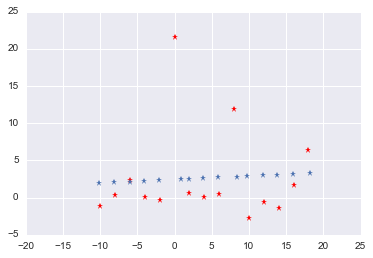

In [24]:
x = np.arange(-10, 20, 2)
err =  np.random.standard_cauchy(size=x.shape[0])
xy = np.vstack([x , 0.05 * x + err ])

x_hat, y_hat = pca_proj(xy[0,:], xy[1,:])

plt.plot(xy[0,:], xy[1,:], 'r*')
plt.plot(x_hat, y_hat, '*')

plt.axis('equal')

x_hat

# ORTHOGONAL VERSION

('World size :', 400, 600)
('Number of readings :', 500)
('Number of neighbours :', 15)
('Consensus :', 4.5)
52 lines found, 0.90% associated readings


/home/raphael/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in double_scalars


(-200, 300)

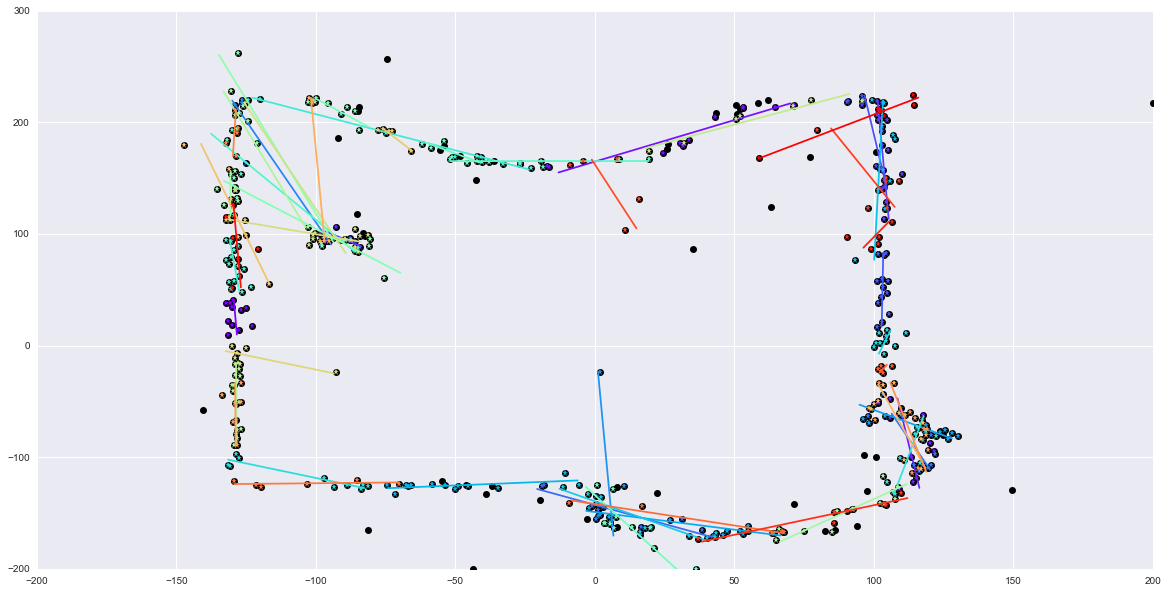

In [52]:
total_readings = np.stack([x_sensor, y_sensor])

# Centering on (200,200), and converting to polar
total_readings = total_readings - 200
r_sensor, theta_sensor = cartesian_to_polar(total_readings[0,:], total_readings[1,:])
total_readings = np.vstack((total_readings, r_sensor, theta_sensor))

# Algorithm hyperparameter
n_iter = 1000
k_neighbours = 15
degrees_range = (15.0 / 360.0) * (2 * np.pi )
consensus = k_neighbours * .3
tolerance = 100 # /!\ SQUARED METERS !!!

print('World size :', x_world, y_world)
print('Number of readings :', len(total_readings[1]))
print('Number of neighbours :', k_neighbours)
print('Consensus :', consensus)

# Algo init variables
i = 0
associated_readings = np.array([[],[],[],[]])
not_associated_readings = total_readings
# We'll stop the algorithm when about 90% of the data points are associated.
associated_readings_proportion = 0
line_models = []

## Coloring... plot... debug
# color=iter(cm.rainbow(np.linspace(0,1,n_iter)))
# plt.xlim(-200,200)
# plt.ylim(-200,300)

# there should be anther termination condition (see pseudocode above)
while i < n_iter and associated_readings_proportion < .90:
    i += 1
    # print('Attempt %d' % i)
    
    # Old method : KNN candidates. Pb : when not contrained, you can get some aberations. (candidates chosen from across the room)
    
    ## First let's use one random point and its k neighbours as candidates
    #middle_candidate_idx = np.random.randint(0, not_associated_readings.shape[1])
    
    # candidates_idx = knn_search(x=not_associated_readings[:,middle_candidate_idx],
    #                            data=not_associated_readings,
    #                            k=k_neighbours)
    
    # New method : Take the K adjascent readings within close range (e.g. : 10 degrees)
      
    # PICK CANDIDATES.
    # 1 - Randomly pick one reference data point among candidates :
    reference_candidate_idx = np.random.randint(0, not_associated_readings.shape[1])
    
    # 2 - Get every candidates within D degrees from reference point
    is_within_range =  np.abs(not_associated_readings[3, :] - not_associated_readings[3, reference_candidate_idx]) < degrees_range
       
    # 3 - Keep K at most random among those within the range 
    # print(is_within_range.nonzero()[0].shape, k_neighbours, not_associated_readings.shape)
    
    candidates_idx = np.random.choice(is_within_range.nonzero()[0],
                                      size=min(k_neighbours, is_within_range.nonzero()[0].shape[0]), 
                                      replace=False)    
    # 4 - That's it.
    candidates = not_associated_readings[:, candidates_idx]

        
    # FIT MODEL
    # 1 - Total least square (via pca projection)
    fitted_x, fitted_y = pca_proj(candidates[0,:], candidates[1,:])
    slope = (fitted_y[-1] - fitted_y[0]) / (fitted_x[-1] - fitted_x[0])
    intercept =  fitted_y[-1] - fitted_x[-1] * slope
    
    # 2 - Compute squared distance to the fitted line and test for tolerance
    sq_dist = (fitted_x - candidates[0,:])**2 + (fitted_y - candidates[1,:])**2
    is_below_tolerance = (sq_dist <= tolerance)

    # print('Best fit : %d (consensus %d)' % (is_below_tolerance.sum(), consensus))
    # print(slope)
       
    
    # 3 - If more than C items fit the model
    if is_below_tolerance.sum() > consensus:
        
        # Refit the model with the best candidates only
        fitted_x, fitted_y = pca_proj(candidates[0, is_below_tolerance], 
                                      candidates[1, is_below_tolerance])

        slope = (fitted_y[-1] - fitted_y[0]) / (fitted_x[-1] - fitted_x[0])
        intercept =  fitted_y[-1] - fitted_x[-1] * slope
        
        # Store the model and related points
        line_models += [Line_model(slope, intercept, candidates[:, is_below_tolerance], np.vstack([fitted_x, fitted_y]))]  # What need for the 'associated_readings' then ?
        associated_readings =  np.hstack([associated_readings, candidates[:, is_below_tolerance]])
        
        # 4 - Update dataset
        # First remove all candidates
        not_associated_readings = np.delete(not_associated_readings, 
                                            candidates_idx, 
                                            axis=1)
        # And add back the worst fit candidates
        not_associated_readings = np.hstack([not_associated_readings, candidates[:, np.logical_not(is_below_tolerance)]])
                
        associated_readings_proportion = float(associated_readings.shape[1]) / float(total_readings.shape[1])
        
        #print('p' ,associated_readings_proportion)

print('%d lines found, %.2f%% associated readings' % (len(line_models), associated_readings_proportion))


plt.figure(figsize=(20,10))
plt.plot(total_readings[0], total_readings[1], 'ko')

#plt.plot(not_associated_readings[0], not_associated_readings[1], 'b*')
#plt.plot(associated_readings[0], associated_readings[1], 'g*')

n = len(line_models)
color=iter(cm.rainbow(np.linspace(0,1,n)))

for m in line_models:
    c = next(color)
    x_min = m.fitted[0].min()
    x_max = m.fitted[0].max()
    x = np.linspace(x_min, x_max)
    plt.plot(x, m.slope * x + m.interceipt, c=c)
    plt.plot(m.points[0], m.points[1],'*', c=c)
    
plt.xlim(-200,200)
plt.ylim(-200,300)

## Old version (index based)

In [ ]:
i = 0
associated_readings = np.array([[],[]])
not_associated_readings = total_readings_sorted
# We'll stop the algorithm when about 90% of the data points are associated.
associated_readings_proportion = 0
line_models = []

# there should be anther termination condition (see pseudocode above)
while i < n_iter and associated_readings_proportion < .90:
    i += 1
    print('Attempt %d' % i)
    
    # Old method : KNN candidates. Pb : when not contrained, you can get some aberations. (candidates chosen from across the room)
    
    ## First let's use one random point and its k neighbours as candidates
    #middle_candidate_idx = np.random.randint(0, not_associated_readings.shape[1])
    
    #candidates_idx = knn_search(x=not_associated_readings[:,middle_candidate_idx],
    #                           data=not_associated_readings,
    #                            k=k_neighbours)

    # New method : Supposing the array of measurement is already sorted by phase, we just take the K adjascent readings.
    middle_candidate_idx = np.random.randint(0, not_associated_readings.shape[1])
    

    candidates = candidates[:, candidates[3, middle_candidate_idx]]
    
    min_candidates_idx = max(middle_candidate_idx - k_neighbours // 2, 0)
    max_candidates_idx = min(middle_candidate_idx + k_neighbours // 2, not_associated_readings.shape[1])
    candidates_idx = np.arange(min_candidates_idx, max_candidates_idx)
    
    candidates = candidates[:, min_candidates_idx : max_candidates_idx]    
    
    # Then fit a linear model and keep those inside the tolerance
    
    # old method : Ordinary least square
    # slope, intercept, rvalue, pvalue, stderr = linregress(candidates[0,:], candidates[1,:])
    # sq_dist = squared_dist(candidates, slope, intercept)
    
    # old method : Total least square (via pca projection)
    fitted_x, fitted_y = pca_proj = candidates[0,:], candidates[1,:]
    
    slope = (fitted_y[-1] - fitted_y[0]) / (fitted_x[-1] - fitted_x[0])
    intercept =  fitted_y[-1] - fitted_x[-1] * slope
    
    sq_dist = (fitted_x - candidates[0,:])**2 + (fitted_y - candidates[1,:])**2
    
    best_fit_candidates = candidates[:, sq_dist <= tolerance]
    worst_fit_candidates = candidates[:, sq_dist > tolerance]

    print(best_fit_candidates.shape[1], consensus)
    
    if best_fit_candidates.shape[1] > consensus:
        fitted_x, fitted_y = pca_proj = best_fit_candidates[0,:], best_fit_candidates[1,:]

        slope = (fitted_y[-1] - fitted_y[0]) / (fitted_x[-1] - fitted_x[0])
        intercept =  fitted_y[-1] - fitted_x[-1] * slope
        line_models += [Line_model(slope, intercept, best_fit_candidates, np.vstack([fitted_x, fitted_y]))]

        associated_readings =  np.hstack([associated_readings, best_fit_candidates])
        
        not_associated_readings = np.delete(not_associated_readings, 
                                            candidates_idx, 
                                            axis=1)
        not_associated_readings = np.hstack([not_associated_readings, worst_fit_candidates])
                
        associated_readings_proportion = float(associated_readings.shape[1]) / float(total_readings.shape[1])
        
        print('p' ,associated_readings_proportion)

print('%d lines found' % len(line_models))


plt.figure(figsize=(20,10))
plt.plot(total_readings[0], total_readings[1], 'ko')

#plt.plot(not_associated_readings[0], not_associated_readings[1], 'b*')
#plt.plot(associated_readings[0], associated_readings[1], 'g*')

n = len(line_models)
color=iter(cm.rainbow(np.linspace(0,1,n)))

for m in line_models:
    c = next(color)
    x_min = m.fitted[0].min()
    x_max = m.fitted[0].max()
    x = np.linspace(x_min, x_max)
    plt.plot(x, m.slope * x + m.interceipt, c=c)
    plt.plot(m.points[0], m.points[1],'*', c=c)
    
plt.xlim(-200,200)
plt.ylim(-200,300)